Goal: predict salary (a scalar) from the other info

In [1]:
# get the data at https://www.kaggle.com/elroyggj/indeed-dataset-data-scientistanalystengineer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import sklearn as sk
from sklearn import preprocessing, impute, ensemble, model_selection, pipeline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dataset description.txt', 'indeed_job_dataset.csv']


In [2]:
df = pd.read_csv("../input/indeed_job_dataset.csv")

In [3]:
df.head(2)

,Unnamed: 0,Job_Title,Link,Queried_Salary,Job_Type,Skill,No_of_Skills,Company,No_of_Reviews,No_of_Stars,Date_Since_Posted,Description,Location,Company_Revenue,Company_Employees,Company_Industry,python,sql,machine learning,r,hadoop,tableau,sas,spark,java,Others,CA,NY,VA,TX,MA,IL,WA,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
0,0,Data Scientist,https://www.indeed.com/rc/clk?jk=6a105f495c36a...,<80000,data_scientist,"['SAP', 'SQL']",2,Express Scripts,3301.0,3.3,1.0,"[<p><b>POSITION SUMMARY</b></p>, <p>\r\r\nThe ...",MO,More than $10B (USD),"10,000+",Health Care,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,1,Data Scientist,https://www.indeed.com/rc/clk?jk=86afd561ea8c6...,<80000,data_scientist,"['Machine Learning', 'R', 'SAS', 'SQL', 'Python']",5,Money Mart Financial Services,NaN,NaN,15.0,"[<p><b>What do we need?</b></p>, <ul><li>\r\r\...",TX,NaN,NaN,NaN,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.Company_Revenue.unique()

array(['More than $10B (USD)', nan, 'Less than $1B (USD)',
       '$1B to $5B (USD)', '$5B to $10B (USD)'], dtype=object)

In [5]:
company_rev_mapping = {'More than $10B (USD)':4, 
        '$5B to $10B (USD)':3, 
        '$1B to $5B (USD)':2, 
        'Less than $1B (USD)':1
        }

In [6]:
df['company_rev'] = df.Company_Revenue.apply(lambda x: company_rev_mapping.get(x,1))

In [7]:
df.Job_Type.unique()

array(['data_scientist', 'data_analyst', 'data_engineer'], dtype=object)

In [8]:
# create dummy dataset where target variable is a float (just for practice). try to predict this.
df['salary_float'] = df.Queried_Salary.apply(lambda x: float(x[1:]) if x[0] in ['<','>'] else float(x[x.find('-') + 1:]))

In [9]:
df.loc[df.salary_float==160000,'salary_float'] = 180000

In [10]:
df[['Queried_Salary','salary_float']].drop_duplicates()

,Queried_Salary,salary_float
0,<80000,80000.0
48,80000-99999,99999.0
281,100000-119999,119999.0
991,120000-139999,139999.0
1761,140000-159999,159999.0
2312,>160000,180000.0


In [11]:
df['salary_float'] = df.salary_float.apply(lambda x: x * random.uniform(0.95,1.05))

In [12]:
df = df.join(pd.get_dummies(df.Job_Type))

In [13]:
df = df.select_dtypes(include=[np.number])

In [17]:
imp = sk.impute.SimpleImputer(missing_values=np.nan, strategy='mean')
for col in df.columns:
    if df[col].isnull().values.any():
        imp.fit(df[[col]])
        df[col] = imp.transform(df[[col]])

In [18]:
df = df[[c for c in df.columns if c!='salary_float'] + ['salary_float']]

In [19]:
df.head(2)

,Unnamed: 0,No_of_Skills,No_of_Reviews,No_of_Stars,Date_Since_Posted,python,sql,machine learning,r,hadoop,tableau,sas,spark,java,Others,CA,NY,VA,TX,MA,IL,WA,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries,company_rev,data_analyst,data_engineer,data_scientist,salary_float
0,0,2,3301.000000,3.300000,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,4,0,0,1,81565.489152
1,1,5,4311.389649,3.845613,15.0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,82411.767542


In [20]:
X_train,X_test,y_train,y_test = sk.model_selection.train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.2)

In [21]:
estimators = {
    "Extra trees": sk.ensemble.ExtraTreesRegressor(n_estimators=20, max_depth=18),
    "Gradient Boosting": sk.ensemble.GradientBoostingRegressor(max_depth=10, min_samples_leaf=3)
}   

In [22]:
def RMSE(estimator,X, y, cv=5):
    cv_results = sk.model_selection.cross_val_score(estimator,X,y,cv=cv,scoring="neg_mean_squared_error")
    return np.sqrt(-cv_results).mean()

In [26]:
for name, estimator in estimators.items():
    #scaler_pipeline = sk.pipeline.make_pipeline(sk.preprocessing.StandardScaler(), estimator)
    #scaler_pipeline.fit(X_train, y_train)
    estimator.fit(X_train, y_train)
    print(name, RMSE(estimator,X_train,y_train))
# with scaler Gradient Boosting 4327.296920128012 Extra trees 4761.390011878919

Extra trees 4678.189566198391
Gradient Boosting 4306.393256262464


In [ ]:
estimator_gb = sk.ensemble.GradientBoostingRegressor(max_depth=10, min_samples_leaf=3)
estimator_gb.fit(X_train, y_train)

In [32]:
param_grid={'n_estimators': [50,100,200], 
            'learning_rate': [0.3,0.5,0.7],
            'min_samples_leaf': [2,3,4,5],
            'max_features': [0.5,0.3,0.1]
           }
# See more at: https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.VAQhQwUk.dpuf

In [33]:
estimator_gb = sk.model_selection.GridSearchCV(estimator=sk.ensemble.GradientBoostingRegressor(), cv=4, param_grid=param_grid)

In [34]:
estimator_gb.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.3, 0.5, 0.7], 'min_samples_leaf': [2, 3, 4, 5], 'max_features': [0.5, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
estimator_gb.best_params_

{'learning_rate': 0.3,
 'max_features': 0.5,
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [36]:
yhat_train = estimator_gb.predict(X_train)
yhat_test = estimator_gb.predict(X_test)

In [37]:
X_train2 = X_train
X_train2['y'] = y_train
X_train2['yhat'] = yhat_train
X_train2['ae'] = X_train2.apply(lambda row: abs(row.y-row.yhat),axis=1)
X_train2['sq_error'] = X_train2.apply(lambda row: (row.y-row.yhat)**2,axis=1)

In [38]:
print(np.mean(X_train2.ae), np.sqrt(np.mean(X_train2.sq_error)))

3028.431381105001 3692.269765227677


In [39]:
X_test2 = X_test
X_test2['y'] = y_test
X_test2['yhat'] = yhat_test
X_test2['ae'] = X_test2.apply(lambda row: abs(row.y-row.yhat),axis=1)
X_test2['sq_error'] = X_test2.apply(lambda row: (row.y-row.yhat)**2,axis=1)

In [41]:
X_test2.head(5)

,Unnamed: 0,No_of_Skills,No_of_Reviews,No_of_Stars,Date_Since_Posted,python,sql,machine learning,r,hadoop,tableau,sas,spark,java,Others,CA,NY,VA,TX,MA,IL,WA,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries,company_rev,data_analyst,data_engineer,data_scientist,y,yhat,ae,sq_error
457,457,5,1435.000000,3.900000,18.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,1,114159.704522,120581.102144,6421.397622,4.123435e+07
4030,4030,4,4311.389649,3.845613,30.0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,117308.883890,120404.847477,3095.963587,9.584991e+06
4919,4919,8,6.000000,4.000000,30.0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,138369.562918,140538.030155,2168.467237,4.702250e+06
3532,3532,7,4311.389649,3.845613,30.0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,101826.377690,100182.602748,1643.774942,2.701996e+06
5106,5106,16,8955.000000,4.000000,30.0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3,0,1,0,135040.831271,139791.389077,4750.557806,2.256780e+07


In [40]:
print(np.mean(X_test2.ae), np.sqrt(np.mean(X_test2.sq_error)))

3560.4773697372657 4362.466112841137


In [45]:
import seaborn as sns

In [54]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 15,10

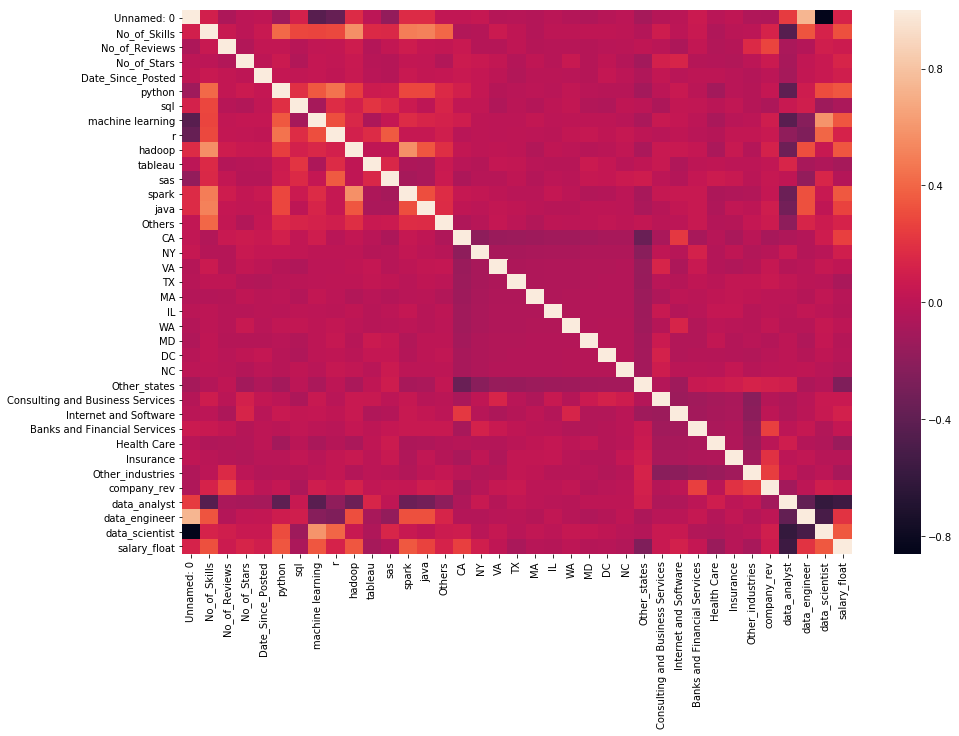

In [55]:
sns.heatmap(df.corr())

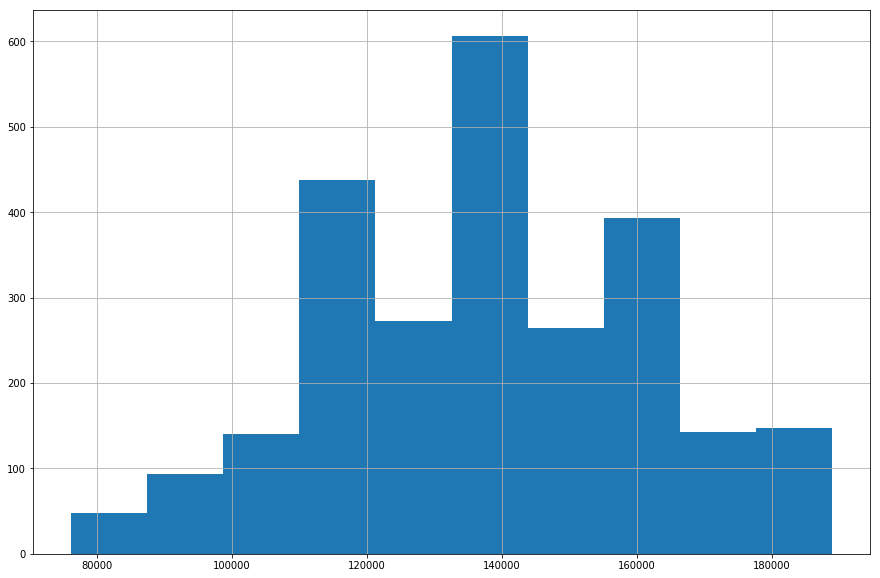

In [57]:
df.query("data_scientist==1").salary_float.hist()